In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from mlxtend.plotting import plot_decision_regions

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.optimizers import Adam

2025-02-02 20:34:50.278544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738508690.327315   17975 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738508690.341133   17975 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 20:34:50.418409: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
X, y = make_moons(n_samples=100, noise=0.25)

X.shape, y.shape

((100, 2), (100,))

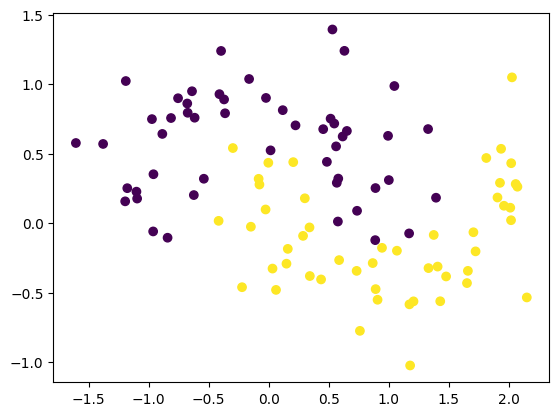

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y)

## Without Regularization

In [4]:
model = Sequential()

model.add(InputLayer((2, )))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

adam = Adam(learning_rate=0.01)
model.compile(loss="binary_crossentropy", optimizer=adam)

# taking 3000 epochs (a lot) knowingly to see overfitting 
history = model.fit(X, y, epochs=3000, batch_size=X.shape[0], validation_split=0.2, verbose=0)

I0000 00:00:1738508719.337905   17975 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2580 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1738508720.471425   18116 service.cc:148] XLA service 0x741004008240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738508720.471448   18116 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-02-02 20:35:20.487246: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738508720.586139   18116 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1738508721.151953   18116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


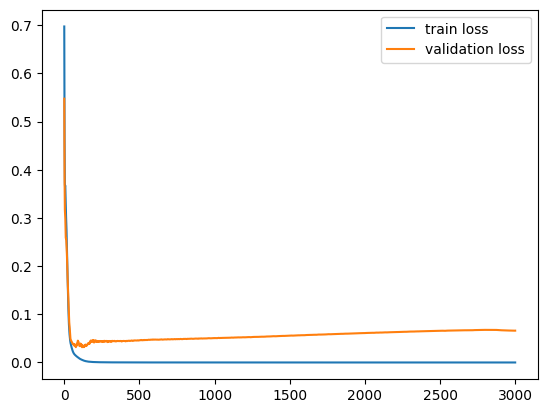

In [5]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

9600/9600 ━━━━━━━━━━━━━━━━━━━━ 6s 616us/step


<Axes: >

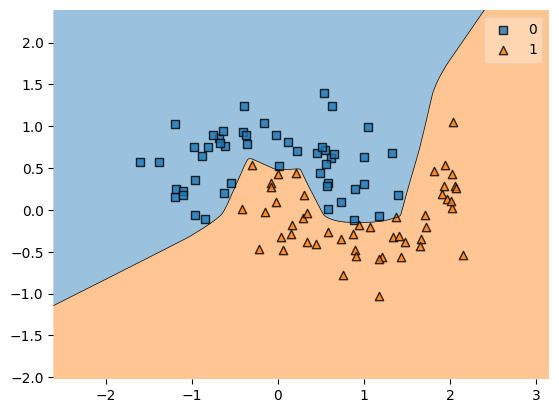

In [6]:
plot_decision_regions(X, y, model)

### Inference 
We can clearly see that the model is overfitting a lot


## With Regularization

In [8]:
from tensorflow.keras.regularizers import L1, L2, L1L2

# we can either do this or initialize it directly in the model 
# regularizer_L1 = L1(l1=0.3)
# regularizer_L2 = L2(l2=0.2)
# regularizer_L1L2 = L1L2(l1=0.1, l2=0.2)

In [16]:
model_2 = Sequential()

model_2.add(InputLayer((2, )))
model_2.add(Dense(128, activation="relu", kernel_regularizer=L2(0.5)))
model_2.add(Dense(128, activation="relu", kernel_regularizer=L2(0.5)))
model_2.add(Dense(1, activation="sigmoid"))

adam = Adam(learning_rate=0.01)
model_2.compile(loss="binary_crossentropy", optimizer=adam)

history_2 = model_2.fit(X, y, epochs=3000, batch_size=X.shape[0], validation_split=0.2, verbose=0)

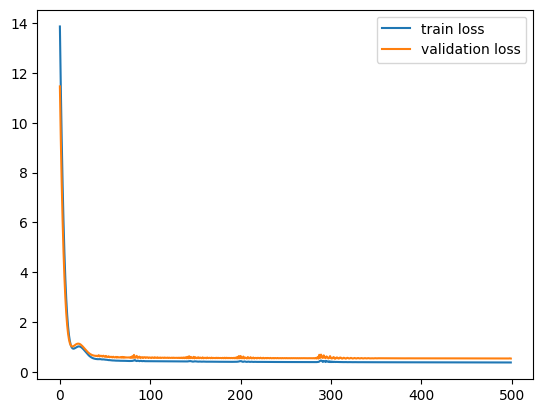

In [17]:
plt.plot(history_2.history["loss"], label="train loss")
plt.plot(history_2.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

9600/9600 ━━━━━━━━━━━━━━━━━━━━ 6s 611us/step


<Axes: >

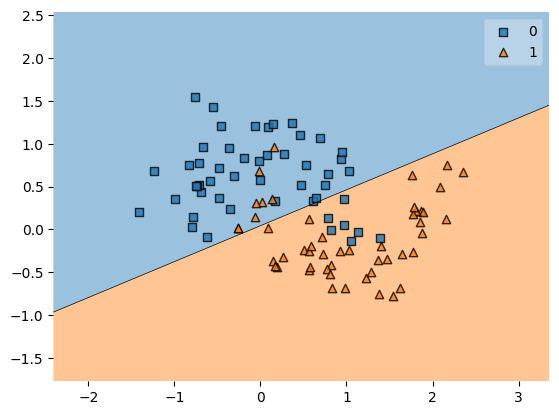

In [18]:
plot_decision_regions(X, y, model_2)

### Inference
Okay too much regularization we need to lower it lol

If it gives results like no line (fully orange or fully blue) or if it gives a straight line then its hella underfitting \
Its not an error if we get a straight classification line. Its just underfitting wayy too much

In [12]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

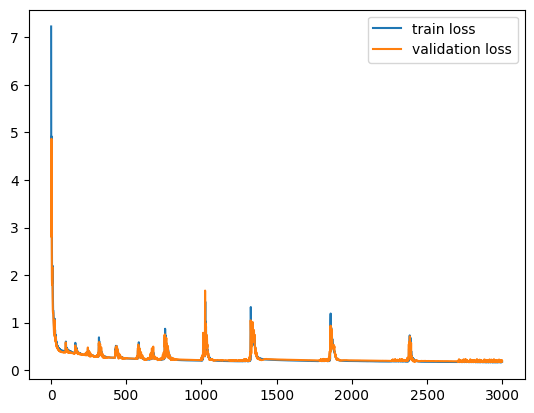

In [13]:
model_2 = Sequential()

model_2.add(InputLayer((2, )))
model_2.add(Dense(128, activation="relu", kernel_regularizer=L2(0.05)))
model_2.add(Dense(128, activation="relu", kernel_regularizer=L2(0.05)))
model_2.add(Dense(1, activation="sigmoid"))

adam = Adam(learning_rate=0.1)
model_2.compile(loss="binary_crossentropy", optimizer=adam)

history_2 = model_2.fit(X, y, epochs=3000, batch_size=X.shape[0], validation_split=0.2, verbose=0)

plt.plot(history_2.history["loss"], label="train loss")
plt.plot(history_2.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

9600/9600 ━━━━━━━━━━━━━━━━━━━━ 7s 697us/step


<Axes: >

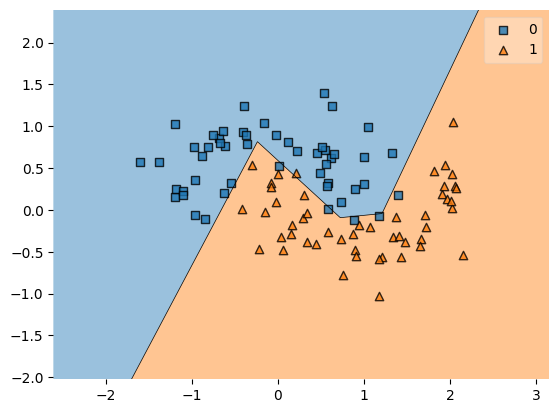

In [14]:
plot_decision_regions(X, y, model_2)

### Inference
As we can see the difference between training and validation loss reduced significantly after regularization\
The decision boundary also looks smoother than before

Tried L1. Didnt work too well\
Maybe cuz it reduced weights to 0 and caused dying ReLU like problem\
L2 pushes weights close to 0 but never 0

## Checking weights with and without Regularization

In [37]:
# Taking weights of first layer (not checking the biases as regularization doesnt effect them)
model_weights_layer_1 = model.layers[0].get_weights()[0].reshape(256)
model_2_weights_layer_1 = model_2.layers[0].get_weights()[0].reshape(256)

# model_weights_layer_1        # without regularization
# model_2_weights_layer_1      # with regularization 

### Inference

We can see that the weights have moved much closer to 0 after regularization

It forces the weights to be smaller (close to 0 but not 0 in L2. In L1 it can reach 0 as well)\
Note that bias is not affected. Regularization doesnt effect bias

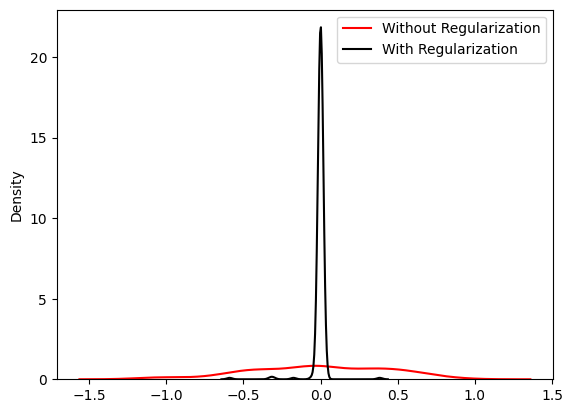

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(model_weights_layer_1, label="Without Regularization", color="red")
sns.kdeplot(model_2_weights_layer_1, label="With Regularization", color="black")
plt.legend()
# plt.xlim(-1, 1)
plt.show()

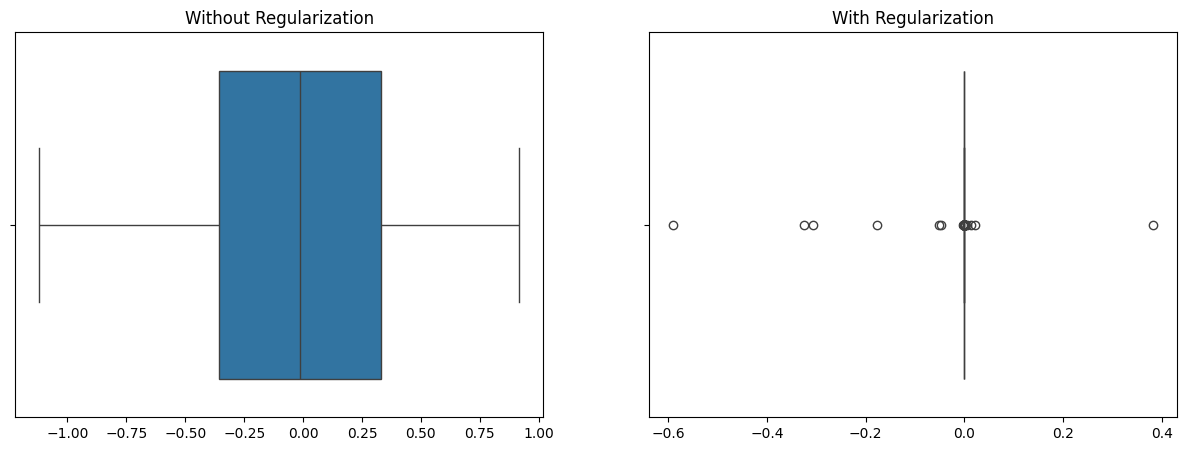

In [65]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

sns.boxplot(x=model_weights_layer_1, ax=ax[0])
sns.boxplot(x=model_2_weights_layer_1, ax=ax[1])

ax[0].set_title("Without Regularization")
ax[1].set_title("With Regularization")

plt.show()

### Inference
- The same result can be seen from the kde plot and box plot as well.
- The weights have moved towards 0 as can be seen from the kde plot
- The range of the weights have shrunken. Much closer to 0 as we can see from the box plot